# Part Three - SARIMA Forecasts On Categories

# Brief

**Background:**

1000ml Retail wants help forecasting their Q3 sales and profit.

**Objective:**
They would like to know sales and profit by category by month.

**Deliverable:**
A 10 min presentation outlining your methodology, reasoning and findings to the (global) sales team.

This presentation should provide actionable information.

# References

* [School Years In Different Countries](https://www.infoplease.com/world/world-statistics/school-years-around-world)
* Angloinfo website has been helpful for school years. Quarter three (Q3) is July, August and September which is back to school season for many countries.

In [0]:
# Import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import statsmodels.api as sm

In [187]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount = False)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [188]:
# Load in data with pandas.

retail_data = pd.read_csv('/content/gdrive/My Drive/1000mlRetail.csv')

# Preview retail data.
retail_data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country,Postal Code,Market,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,32298,CA-2016-124891,2016-07-31,2016-07-31,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,United States,10024.0,US,East,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical
1,26341,IN-2017-77878,2017-02-05,2017-02-07,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,Australia,NaN,APAC,Oceania,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical
2,25330,IN-2017-71249,2017-10-17,2017-10-18,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,Australia,NaN,APAC,Oceania,TEC-PH-10004664,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium
3,13524,ES-2017-1579342,2017-01-28,2017-01-30,First Class,KM-16375,Katherine Murray,Home Office,Berlin,Berlin,Germany,NaN,EU,Central,TEC-PH-10004583,Technology,Phones,"Motorola Smart Phone, Cordless",2892.510,5,0.1,-96.5400,910.16,Medium
4,47221,SG-2017-4320,2017-11-05,2017-11-06,Same Day,RH-9495,Rick Hansen,Consumer,Dakar,Dakar,Senegal,NaN,Africa,Africa,TEC-SHA-10000501,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.960,8,0.0,311.5200,903.04,Critical


## Convert Times To DateTime

In [0]:
retail_data['Order Date'] = pd.to_datetime(retail_data['Order Date'])

retail_data['Ship Date'] = pd.to_datetime(retail_data['Ship Date'])

In [190]:
# Check that Order Date & Ship Date are indeed datetimes.

retail_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 24 columns):
Row ID            51290 non-null int64
Order ID          51290 non-null object
Order Date        51290 non-null datetime64[ns]
Ship Date         51290 non-null datetime64[ns]
Ship Mode         51290 non-null object
Customer ID       51290 non-null object
Customer Name     51290 non-null object
Segment           51290 non-null object
City              51290 non-null object
State             51290 non-null object
Country           51290 non-null object
Postal Code       9994 non-null float64
Market            51290 non-null object
Region            51290 non-null object
Product ID        51290 non-null object
Category          51290 non-null object
Sub-Category      51290 non-null object
Product Name      51290 non-null object
Sales             51290 non-null float64
Quantity          51290 non-null int64
Discount          51290 non-null float64
Profit            51290 non-null fl

In [191]:
# Look at Order Date info.

retail_data['Order Date'].describe()

count                   51290
unique                   1430
top       2018-06-18 00:00:00
freq                      135
first     2015-01-01 00:00:00
last      2018-12-31 00:00:00
Name: Order Date, dtype: object

In [192]:
# Look at Ship Date info.

retail_data['Ship Date'].describe()

count                   51290
unique                   1460
top       2018-11-22 00:00:00
freq                      130
first     2015-01-01 00:00:00
last      2018-12-31 00:00:00
Name: Ship Date, dtype: object

In [0]:
# Create Order_Date_Month column for order dates by month only
# Reference: https://stackoverflow.com/questions/18233107/pandas-convert-datetime-to-end-of-month

retail_data['Order_Date_Month'] = retail_data['Order Date'].astype('datetime64[M]')

In [194]:
# Group by Month and find total profit for each month:

order_profits_monthly = retail_data.groupby(['Order_Date_Month'])['Profit'].sum()

order_profits_monthly.tail()

Order_Date_Month
2018-08-01    53542.89496
2018-09-01    67979.45110
2018-10-01    58209.83476
2018-11-01    62856.58790
2018-12-01    46916.52068
Name: Profit, dtype: float64

# SARIMA Forecasting Models On Category

I would like to do SARIMA forecasting on monthly profits (instead of sales) for each category. Recall that the three categories are:

* Furniture
* Technology
* Office Supplies


As each category has its own time series plot of monthly order profits, the SARIMA forecasting models will be different.

# 1) SARIMA Model On Office Supplies Profits

I want to look at the time data for profits on office supplies from 2015 to 2018. An initial time plot.

In [195]:
# Retail data with office supplies only:

retail_data_office = retail_data[retail_data['Category'] == 'Office Supplies']

retail_data_office.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country,Postal Code,Market,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority,Order_Date_Month
8,40155,CA-2018-135909,2018-10-14,2018-10-21,Standard Class,JW-15220,Jane Waco,Corporate,Sacramento,California,United States,95823.0,US,West,OFF-BI-10003527,Office Supplies,Binders,Fellowes PB500 Electric Punch Plastic Comb Bin...,5083.960,5,0.2,1906.485,867.69,Low,2018-10-01
10,34577,CA-2015-102988,2015-04-05,2015-04-09,Second Class,GM-14695,Greg Maxwell,Corporate,Alexandria,Virginia,United States,22304.0,US,South,OFF-SU-10002881,Office Supplies,Supplies,Martin Yale Chadless Opener Electric Letter Op...,4164.050,5,0.0,83.281,846.54,High,2015-04-01
14,27704,IN-2017-73951,2017-06-06,2017-06-08,Second Class,PF-19120,Peter Fuller,Consumer,Mudanjiang,Heilongjiang,China,NaN,APAC,North Asia,OFF-AP-10003500,Office Supplies,Appliances,"KitchenAid Microwave, White",3701.520,12,0.0,1036.080,804.54,Critical,2017-06-01
15,13779,ES-2018-5099955,2018-07-31,2018-08-03,Second Class,BP-11185,Ben Peterman,Corporate,Paris,Ile-de-France,France,NaN,EU,Central,OFF-AP-10000423,Office Supplies,Appliances,"Breville Refrigerator, Red",1869.588,4,0.1,186.948,801.66,Critical,2018-07-01
17,12069,ES-2018-1651774,2018-09-08,2018-09-14,Standard Class,PJ-18835,Patrick Jones,Corporate,Prato,Tuscany,Italy,NaN,EU,South,OFF-AP-10004512,Office Supplies,Appliances,"Hoover Stove, Red",7958.580,14,0.0,3979.080,778.32,Low,2018-09-01


In [196]:
# From retail data with office supplies only, group by month and find 
# total profits for each month.

office_supp_mth_profits = retail_data_office.groupby(['Order_Date_Month'])['Profit'].sum()

office_supp_mth_profits.head()

Order_Date_Month
2015-01-01    4573.7381
2015-02-01    2336.1860
2015-03-01    6411.4282
2015-04-01    5678.5985
2015-05-01    5082.5060
Name: Profit, dtype: float64

Text(0.5, 1.0, 'Monthly Order Profits On Office Supplies\n')

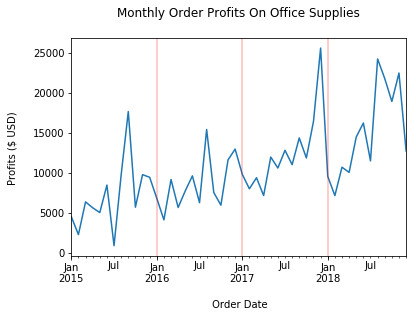

In [197]:
# Monthly Order Profits On Office Supplies (2015 - 2017)

office_supp_mth_profits.plot()

plt.xlabel('\n Order Date')
plt.ylabel('Profits ($ USD) \n')

# Vertical lines at start of each year
plt.axvline(x = '2016-01-01', linewidth=2, color='red', alpha = 0.2) 
plt.axvline(x = '2017-01-01', linewidth=2, color='red', alpha = 0.2)
plt.axvline(x = '2018-01-01', linewidth=2, color='red', alpha = 0.2)

plt.title('Monthly Order Profits On Office Supplies\n')

## Using auto.arima() For Model Selection On Office Supplies Profits

In [198]:
pip install pyramid-arima

In [0]:
from pyramid.arima import auto_arima

### Train - Test Split On Office Supplies Monthly Profits

In [200]:
# Preview office data:

office_supp_mth_profits.tail()

Order_Date_Month
2018-08-01    24209.9150
2018-09-01    21769.7576
2018-10-01    18911.3409
2018-11-01    22452.7815
2018-12-01    12751.2685
Name: Profit, dtype: float64

In [201]:
# Training data is monthly profits from 2015 - 2017 

office_profits_mth_train = office_supp_mth_profits[office_supp_mth_profits.index < '2018-01-01']

office_profits_mth_train.tail()

Order_Date_Month
2017-08-01    11041.1275
2017-09-01    14370.4206
2017-10-01    11880.3440
2017-11-01    16435.1859
2017-12-01    25563.4914
Name: Profit, dtype: float64

In [202]:
# Test data is monthly profits on 2018.

office_profits_mth_test = office_supp_mth_profits[~(office_supp_mth_profits.index < '2018-01-01')]

office_profits_mth_test.tail()

Order_Date_Month
2018-08-01    24209.9150
2018-09-01    21769.7576
2018-10-01    18911.3409
2018-11-01    22452.7815
2018-12-01    12751.2685
Name: Profit, dtype: float64

In [203]:
# Using auto arima with Adj Dickey-Fuller stationarity test and BIC criterion.
# Got SARIMA(1, 0, 0)(0, 0, 0, 12)

auto_arima(office_profits_mth_train, test =  'adf', m = 12, stepwise = True, trace = True,
           information_criterion = 'bic')

/usr/local/lib/python3.6/dist-packages/pyramid/arima/auto.py:864: ModelFitWarning: Unable to fit ARIMA for order=(2, 0, 2) seasonal_order=(1, 0, 1, 12); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.6/dist-packages/pyramid/arima/auto.py:864: ModelFitWarning: Unable to fit ARIMA for order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starti

Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=713.713, BIC=716.880, Fit time=0.009 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=711.312, BIC=717.646, Fit time=0.060 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=715.357, BIC=720.108, Fit time=0.036 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=710.940, BIC=715.690, Fit time=0.020 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=710.287, BIC=716.621, Fit time=0.035 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=712.090, BIC=720.008, Fit

/usr/local/lib/python3.6/dist-packages/pyramid/arima/auto.py:864: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 0) seasonal_order=(0, 0, 1, 12); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/usr/local/lib/python3.6/dist-packages/pyramid/arima/auto.py:864: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 0) seasonal_order=(1, 0, 1, 12); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(1, 0, 0),
      out_of_sample_size=0, scoring='mse', scoring_args={},
      seasonal_order=(0, 0, 0, 12), solver='lbfgs', start_params=None,
      suppress_warnings=False, transparams=True, trend='c')

In [204]:
# Using auto arima with Adj Dickey-Fuller stationarity test and AIC criterion.
# Got SARIMA(1, 0, 1)(1, 0, 0, 12)

auto_arima(office_profits_mth_train, test =  'adf', m = 12, stepwise = True, trace = True,
           information_criterion = 'aic')

/usr/local/lib/python3.6/dist-packages/pyramid/arima/auto.py:864: ModelFitWarning: Unable to fit ARIMA for order=(2, 0, 2) seasonal_order=(1, 0, 1, 12); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.6/dist-packages/pyramid/arima/auto.py:864: ModelFitWarning: Unable to fit ARIMA for order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/usr/local/lib/python3.6/dist-packages/pyramid/arima/auto.py:864: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 0) seasonal_order=(0, 0, 1, 12); data is likely non-stationary. (if you do not want to s

Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=713.713, BIC=716.880, Fit time=0.009 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=711.312, BIC=717.646, Fit time=0.060 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=710.940, BIC=715.690, Fit time=0.020 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=712.058, BIC=718.392, Fit time=0.034 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=710.287, BIC=716.621, Fit time=0.038 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 12); AIC=710.574, BIC=720.075, Fit

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.6/dist-packages/pyramid/arima/auto.py:864: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 1) seasonal_order=(1, 0, 1, 12); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/usr/local/lib/python3.6/dist-packages/pyramid/arima/auto.py:864: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 1) seasonal_order=(2, 0, 1, 12); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starti

Fit ARIMA: order=(2, 0, 1) seasonal_order=(1, 0, 0, 12); AIC=711.231, BIC=720.732, Fit time=0.156 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(1, 0, 0, 12); AIC=712.942, BIC=722.444, Fit time=0.144 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=715.357, BIC=720.108, Fit time=0.040 seconds


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 0, 12); AIC=710.409, BIC=721.494, Fit time=0.243 seconds


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Fit ARIMA: order=(1, 0, 1) seasonal_order=(2, 0, 0, 12); AIC=711.864, BIC=721.365, Fit time=0.257 seconds
Total fit time: 1.293 seconds


ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(1, 0, 1),
      out_of_sample_size=0, scoring='mse', scoring_args={},
      seasonal_order=(1, 0, 0, 12), solver='lbfgs', start_params=None,
      suppress_warnings=False, transparams=True, trend='c')

In [205]:
# Using auto arima with kpss stationarity test and AIC criterion.
# Got SARIMA(2, 1, 0)(0, 0, 0, 12)

auto_arima(office_profits_mth_train, test = 'kpss', m = 12, stepwise = True, trace = True,
           information_criterion = 'bic')

/usr/local/lib/python3.6/dist-packages/pyramid/arima/auto.py:864: ModelFitWarning: Unable to fit ARIMA for order=(2, 1, 2) seasonal_order=(1, 0, 1, 12); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/usr/local/lib/python3.6/dist-packages/pyramid/arima/auto.py:864: ModelFitWarning: Unable to fit ARIMA for order=(0, 1, 1) seasonal_order=(0, 0, 1, 12); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/usr/local/lib/python3.6/dist-packages/pyramid/arima/auto.py:864: ModelFitWarning: Unable to fit ARIMA for order=(1, 1, 0) seasonal_order=(0, 0, 1, 12); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/usr/local/lib/python3.6/dist-packages/pyramid/arima/auto.py:864: ModelFitWarning: Unable to fit ARIMA for order=(1, 1, 0) seasonal_order=(1, 0, 1, 12); data is likel

Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 12); AIC=696.489, BIC=699.599, Fit time=0.011 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 12); AIC=691.381, BIC=697.602, Fit time=0.057 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 12); AIC=691.194, BIC=695.860, Fit time=0.032 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 0, 0, 12); AIC=684.549, BIC=690.770, Fit time=0.032 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 12); AIC=686.559, BIC=694.335, Fit time=0.067 seconds
Fit ARIMA: order=(3, 1, 1) seasonal_order=(0, 0, 0, 12); AIC=688.556, BIC=697.888, Fit

/usr/local/lib/python3.6/dist-packages/pyramid/arima/auto.py:864: ModelFitWarning: Unable to fit ARIMA for order=(2, 1, 0) seasonal_order=(0, 0, 1, 12); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/usr/local/lib/python3.6/dist-packages/pyramid/arima/auto.py:864: ModelFitWarning: Unable to fit ARIMA for order=(2, 1, 0) seasonal_order=(1, 0, 1, 12); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(2, 1, 0),
      out_of_sample_size=0, scoring='mse', scoring_args={},
      seasonal_order=(0, 0, 0, 12), solver='lbfgs', start_params=None,
      suppress_warnings=False, transparams=True, trend='c')

## Model Fit On SARIMA(1, 0, 0)(1, 0, 0, 12)

In [209]:
# Reference: https://www.datasciencesmachinelearning.com/2019/01/arimasarima-in-python.html

office_mth_profits_model_100 = sm.tsa.statespace.SARIMAX(office_profits_mth_train,
                                       order = (1, 0, 0),
                                       seasonal_order = (1, 0, 0, 12),
                                       enforce_stationarity = False,
                                       enforce_invertibility = False)

results_office_profits_model_100 = office_mth_profits_model_100.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


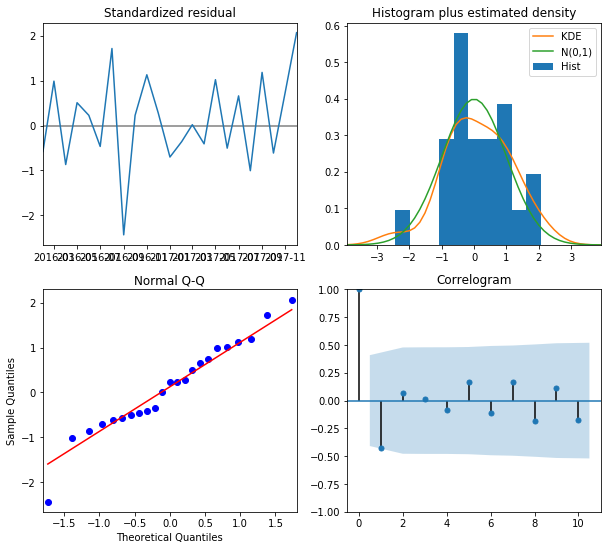

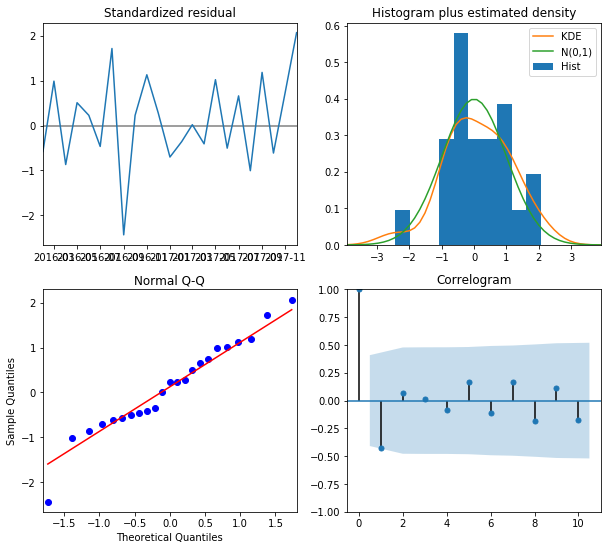

In [210]:
# Model Diagnostics:

results_office_profits_model_100.plot_diagnostics(figsize = (10, 9))

### Forecasts On SARIMA(1, 0, 0) x (1, 0, 0, 12)

In [211]:
# Obtain forecasts for 2019 from SARIMA(1, 0, 0) x (0, 0, 0, 12) on office supplies mthly profits.

forecasts_office_profits_100 = results_office_profits_model_100.get_forecast(steps = 12)

forecasts_office_profits_100.summary_frame()

Profit,mean,mean_se,mean_ci_lower,mean_ci_upper
2018-01-01,25513.829716,4082.576473,17512.126865,33515.532567
2018-02-01,25770.083631,5854.964223,14294.564623,37245.602638
2018-03-01,26743.649159,7272.770428,12489.281053,40998.017266
2018-04-01,26948.056320,8518.326720,10252.442739,43643.669900
2018-05-01,28706.322424,9661.606158,9769.922321,47642.722527
2018-06-01,29138.517730,10738.284157,8091.867527,50185.167934
2018-07-01,30371.205393,11769.500807,7303.407696,53439.003090
2018-08-01,30750.522864,12769.046888,5723.650846,55777.394882
2018-09-01,32272.228971,13746.552438,5329.481282,59214.976660
2018-10-01,32541.947253,14709.097719,3712.645479,61371.249027


In [212]:
# Obtain means from forecasts:

forecasts_mean_office_profits100 = forecasts_office_profits_100.summary_frame()['mean']

forecasts_mean_office_profits100

2018-01-01    25513.829716
2018-02-01    25770.083631
2018-03-01    26743.649159
2018-04-01    26948.056320
2018-05-01    28706.322424
2018-06-01    29138.517730
2018-07-01    30371.205393
2018-08-01    30750.522864
2018-09-01    32272.228971
2018-10-01    32541.947253
2018-11-01    34376.973109
2018-12-01    37236.811992
Freq: MS, Name: mean, dtype: float64

### RMSE, Correlation & Mean Abs. Pct Error

In [213]:
# Root Mean Squared Error - Square of Predictions - Acutal (Test) Values:

mse_profit_office_100 = np.mean((forecasts_mean_office_profits100 - office_profits_mth_test)**2)

rmse_profit_office_100 = mse_profit_office_100 ** 0.5

rmse_profit_office_100

15664.237140944684

In [214]:
# Correlation Between Forecasted 2018 Values & Actual 2018 Sales Per Month
# Got negative correlation which is bad I think.

corr_profits_office_100 = np.corrcoef(forecasts_mean_office_profits100, office_profits_mth_test)

corr_profits_office_100

array([[1.        , 0.58987098],
       [0.58987098, 1.        ]])

In [215]:
# Mean Absolute Percentage Error
# 1.22 -> very bad prediction on test set

mean_abs_percent_error_profits_100 = np.mean(np.abs(forecasts_mean_office_profits100 - office_profits_mth_test)/np.abs(office_profits_mth_test)) 

mean_abs_percent_error_profits_100

1.2288990409173477

## Model Fit On SARIMA(1, 0, 1)(1, 0, 0, 12)

In [28]:
# Reference: https://www.datasciencesmachinelearning.com/2019/01/arimasarima-in-python.html

office_mth_profits_model_101 = sm.tsa.statespace.SARIMAX(office_profits_mth_train,
                                       order = (1, 0, 1),
                                       seasonal_order = (1, 0, 0, 12),
                                       enforce_stationarity = False,
                                       enforce_invertibility = False)

results_office_profits_model_101 = office_mth_profits_model_101.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


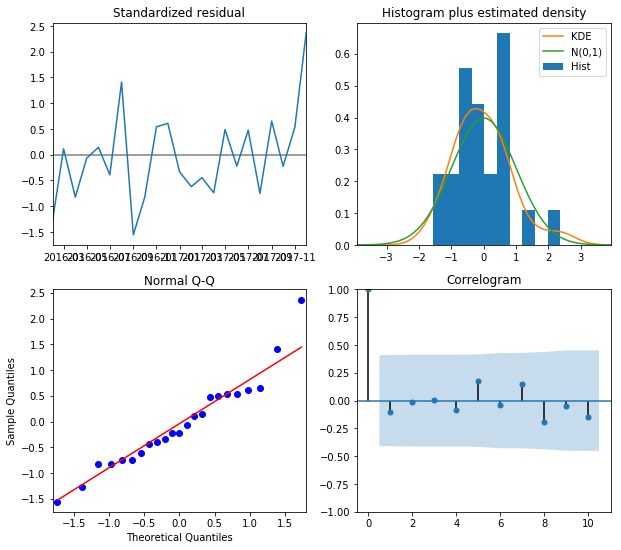

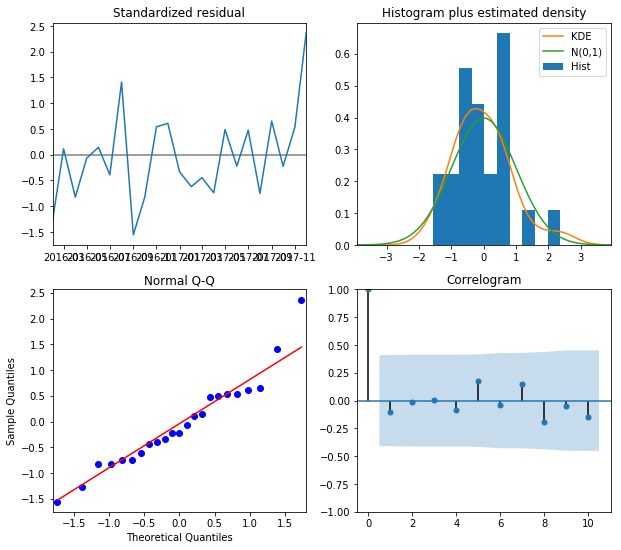

In [102]:
# Model Diagnostics On SARIMA(1, 0, 1)(1, 0, 0, 12)

results_office_profits_model_101.plot_diagnostics(figsize = (10, 9))

### Forecasted Profits On Office Supplies

In [29]:
# Obtain forecasts for 2019 from SARIMA(1, 0, 1) x (1, 0, 0, 12) on office supplies mthly profits.

forecasts_office_profits_101 = results_office_profits_model_101.get_forecast(steps = 12)

forecasts_office_profits_101.summary_frame()

Profit,mean,mean_se,mean_ci_lower,mean_ci_upper
2018-01-01,19349.334726,4072.270079,11367.832036,27330.837416
2018-02-01,19744.500543,4336.223035,11245.659564,28243.341521
2018-03-01,20900.190738,4608.268284,11868.150871,29932.230605
2018-04-01,21281.075662,4889.162465,11698.493315,30863.658008
2018-05-01,23289.818732,5179.646889,13137.897378,33441.740087
2018-06-01,23950.792191,5480.456452,13209.294925,34692.289457
2018-07-01,25463.731149,5792.326731,14110.979369,36816.482929
2018-08-01,26120.568691,6115.999750,14133.429453,38107.707930
2018-09-01,27985.990438,6452.228811,15339.854349,40632.126528
2018-10-01,28586.622473,6801.782641,15255.373467,41917.871480


In [30]:
# Obtain forecasts for 2019 from SARIMA(1, 0, 1) x (1, 0, 0, 12) on office supplies mthly profits.

forecasts_mean_office_profits101 = forecasts_office_profits_101.summary_frame()['mean']

forecasts_mean_office_profits101

2018-01-01    19349.334726
2018-02-01    19744.500543
2018-03-01    20900.190738
2018-04-01    21281.075662
2018-05-01    23289.818732
2018-06-01    23950.792191
2018-07-01    25463.731149
2018-08-01    26120.568691
2018-09-01    27985.990438
2018-10-01    28586.622473
2018-11-01    30836.567094
2018-12-01    34179.027066
Freq: MS, Name: mean, dtype: float64

### RMSE, Correlation & Mean Abs. Pct Error

In [31]:
# Root Mean Squared Error - Square of Predictions - Acutal (Test) Values:

mse_profit_office_101 = np.mean((forecasts_mean_office_profits101 - office_profits_mth_test)**2)

rmse_profit_office_101 = mse_profit_office_101 ** 0.5

rmse_profit_office_101

11100.121525583547

In [32]:
# Correlation Between Forecasted 2018 Values & Actual 2018 Sales Per Month

corr_profits_office_101 = np.corrcoef(forecasts_mean_office_profits101, office_profits_mth_test)

corr_profits_office_101

array([[1.        , 0.59915516],
       [0.59915516, 1.        ]])

In [33]:
# Mean Absolute Percentage Error
# 83.7 % Error on Test set, poor prediction.

mean_abs_percent_error_profits_101 = np.mean(np.abs(forecasts_mean_office_profits101 - office_profits_mth_test)/np.abs(office_profits_mth_test)) 

mean_abs_percent_error_profits_101

0.8371056387174552

## Model Fit On SARIMA(2, 1, 0)(0, 0, 0, 12)

In [231]:
# Reference: https://www.datasciencesmachinelearning.com/2019/01/arimasarima-in-python.html

office_mth_profits_model_210 = sm.tsa.statespace.SARIMAX(office_profits_mth_train,
                                       order = (2, 1, 0),
                                       seasonal_order = (0, 0, 0, 12),
                                       enforce_stationarity = False,
                                       enforce_invertibility = False)

results_office_profits_model_210 = office_mth_profits_model_210.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


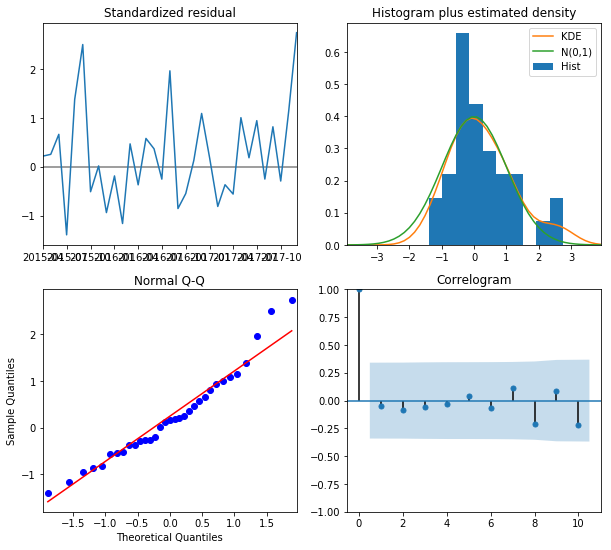

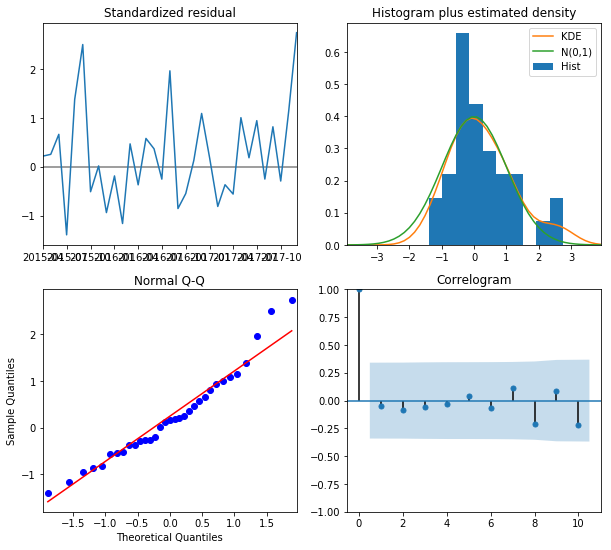

In [232]:
# Model Diagnostics On SARIMA(2, 1, 0)(0, 0, 0, 12)

results_office_profits_model_210.plot_diagnostics(figsize = (10, 9))

### Forecasted Profits On Office Supplies

In [233]:
# Obtain forecasts for 2019 from SARIMA(2, 1, 0) x (0, 0, 0, 12) on office supplies mthly profits.

forecasts_office_profits_210 = results_office_profits_model_210.get_forecast(steps = 12)

forecasts_office_profits_210.summary_frame()

Profit,mean,mean_se,mean_ci_lower,mean_ci_upper
2018-01-01,17042.605329,3974.516009,9252.697095,24832.513562
2018-02-01,18092.715714,4177.929770,9904.123835,26281.307593
2018-03-01,21779.409329,4308.645183,13334.619949,30224.198709
2018-04-01,18745.387087,5031.343504,8884.135026,28606.639148
2018-05-01,18894.133274,5302.763408,8500.907976,29287.358573
2018-06-01,20359.061101,5511.333179,9557.046563,31161.075640
2018-07-01,19292.025888,5896.134945,7735.813748,30848.238027
2018-08-01,19257.471645,6159.916600,7184.256960,31330.686329
2018-09-01,19831.393711,6387.003694,7313.096502,32349.690921
2018-10-01,19461.253603,6667.427587,6393.335663,32529.171543


In [234]:
# Obtain forecasts for 2018 for the ARIMA model

forecasts_mean_office_profits210 = forecasts_office_profits_210.summary_frame()['mean']

forecasts_mean_office_profits210

2018-01-01    17042.605329
2018-02-01    18092.715714
2018-03-01    21779.409329
2018-04-01    18745.387087
2018-05-01    18894.133274
2018-06-01    20359.061101
2018-07-01    19292.025888
2018-08-01    19257.471645
2018-09-01    19831.393711
2018-10-01    19461.253603
2018-11-01    19415.337519
2018-12-01    19637.359678
Freq: MS, Name: mean, dtype: float64

### RMSE, Correlation & Mean Abs. Pct Error

In [235]:
# Root Mean Squared Error - Square of Predictions - Acutal (Test) Values:

mse_profit_office_210 = np.mean((forecasts_mean_office_profits210 - office_profits_mth_test)**2)

rmse_profit_office_210 = mse_profit_office_210 ** 0.5

rmse_profit_office_210

6792.352125868686

In [236]:
# Correlation Between Forecasted 2018 Values & Actual 2018 Sales Per Month

corr_profits_office_210 = np.corrcoef(forecasts_mean_office_profits210, office_profits_mth_test)

corr_profits_office_210

array([[1.        , 0.26686098],
       [0.26686098, 1.        ]])

In [237]:
# Mean Absolute Percentage Error
# 53.4 % Error on Test set, poor prediction.

mean_abs_percent_error_profits_210 = np.mean(np.abs(forecasts_mean_office_profits210 - office_profits_mth_test)/np.abs(office_profits_mth_test)) 

mean_abs_percent_error_profits_210

0.5344247729943661

## Final Model Fit On Office Supplies - SARIMA(2, 1, 0)(0, 0, 0, 12)

In [238]:
# Reference: https://www.datasciencesmachinelearning.com/2019/01/arimasarima-in-python.html

office_profits_finalmodel = sm.tsa.statespace.SARIMAX(office_supp_mth_profits,
                                       order = (2, 1, 0),
                                       seasonal_order = (0, 0, 0, 12),
                                       enforce_stationarity = False,
                                       enforce_invertibility = False)

results_office_profits_finalmodel = office_profits_finalmodel.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [275]:
# Obtain forecasts for 2019 from SARIMA(2, 1, 0) on office supplies mthly profits.

forecasts_office_profits_final = results_office_profits_finalmodel.get_forecast(steps = 12)

forecasts_office_profits_final.summary_frame()

Profit,mean,mean_se,mean_ci_lower,mean_ci_upper
2019-01-01,17022.305585,4568.402800,8068.400629,25976.210541
2019-02-01,18784.535152,4914.326983,9152.631257,28416.439047
2019-03-01,15810.288921,5118.601238,5778.014843,25842.562999
2019-04-01,16817.045473,5880.146956,5292.169216,28341.921730
2019-05-01,17539.958334,6271.672864,5247.705399,29832.211269
2019-06-01,16653.271976,6569.979562,3776.348656,29530.195296
2019-07-01,16865.031067,6998.515780,3148.192193,30581.869940
2019-08-01,17133.886156,7347.482863,2733.084367,31534.687944
2019-09-01,16876.888751,7652.578115,1878.111257,31875.666245
2019-10-01,16911.725493,7983.957939,1263.455478,32559.995508


In [240]:
forecasts_office_profits_mean = forecasts_office_profits_final.summary_frame()['mean']

forecasts_office_profits_mean.tail()

2019-08-01    17133.886156
2019-09-01    16876.888751
2019-10-01    16911.725493
2019-11-01    17005.668373
2019-12-01    16933.385213
Freq: MS, Name: mean, dtype: float64

In [241]:
# Monthly profits on office supplies before 2019:

monthly_profits_pre2019 = office_supp_mth_profits[office_supp_mth_profits.index < '2019-01-01']

monthly_profits_pre2019.tail()

Order_Date_Month
2018-08-01    24209.9150
2018-09-01    21769.7576
2018-10-01    18911.3409
2018-11-01    22452.7815
2018-12-01    12751.2685
Name: Profit, dtype: float64

In [242]:
# Monthly profits before 2019 and including the forecasted 
# January 2019 sales (to connect lines in plot)

office_profits_pre2019 = office_supp_mth_profits.append(forecasts_office_profits_mean.head(1))

office_profits_pre2019.tail()

2018-09-01    21769.757600
2018-10-01    18911.340900
2018-11-01    22452.781500
2018-12-01    12751.268500
2019-01-01    17022.305585
dtype: float64

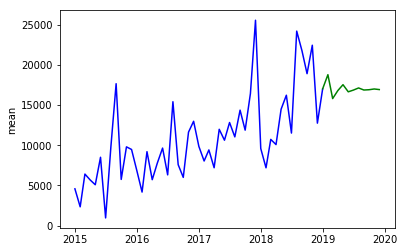

In [243]:
# Line Plots (Blue is historical data, green is forecasted)

sns.lineplot(x = office_profits_pre2019.index, y = office_profits_pre2019, color = 'blue')
sns.lineplot(x = forecasts_office_profits_mean.index, y = forecasts_office_profits_mean, color = 'green')
#plt.axvline(pd.Timestamp('2019-01-01'), color= 'green', alpha = 0.5)

# 2) SARIMA Model On Monthly Furniture Profits

In [88]:
# Retail data with furniture only:

retail_data_furn = retail_data[retail_data['Category'] == 'Furniture']

retail_data_furn.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country,Postal Code,Market,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority,Order_Date_Month
1,26341,IN-2017-77878,2017-02-05,2017-02-07,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,Australia,NaN,APAC,Oceania,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical,2017-02-01
6,30570,IN-2015-81826,2015-11-07,2015-11-09,First Class,TS-21340,Toby Swindell,Consumer,Porirua,Wellington,New Zealand,NaN,APAC,Oceania,FUR-CH-10004050,Furniture,Chairs,"Novimex Executive Leather Armchair, Adjustable",1822.080,4,0.0,564.8400,894.77,Critical,2015-11-01
7,31192,IN-2016-86369,2016-04-14,2016-04-18,Standard Class,MB-18085,Mick Brown,Consumer,Hamilton,Waikato,New Zealand,NaN,APAC,Oceania,FUR-TA-10002958,Furniture,Tables,"Chromcraft Conference Table, Fully Assembled",5244.840,6,0.0,996.4800,878.38,High,2016-04-01
9,40936,CA-2016-116638,2016-01-28,2016-01-31,Second Class,JH-15985,Joseph Holt,Consumer,Concord,North Carolina,United States,28027.0,US,South,FUR-TA-10000198,Furniture,Tables,Chromcraft Bull-Nose Wood Oval Conference Tabl...,4297.644,13,0.4,-1862.3124,865.74,Critical,2016-01-01
11,28879,ID-2016-28402,2016-04-19,2016-04-22,First Class,AJ-10780,Anthony Jacobs,Corporate,Kabul,Kabul,Afghanistan,NaN,APAC,Central Asia,FUR-TA-10001889,Furniture,Tables,"Bevis Conference Table, Fully Assembled",4626.150,5,0.0,647.5500,835.57,High,2016-04-01


In [89]:
# From retail data with furniture only, group by month and find 
# total profits for each month.

furn_mth_profits = retail_data_furn.groupby(['Order_Date_Month'])['Profit'].sum()

furn_mth_profits.head()

Order_Date_Month
2015-01-01     691.2009
2015-02-01    2878.6208
2015-03-01    4888.2878
2015-04-01    2085.5382
2015-05-01     546.0237
Name: Profit, dtype: float64

Text(0.5, 1.0, 'Monthly Order Profits On Furniture\n')

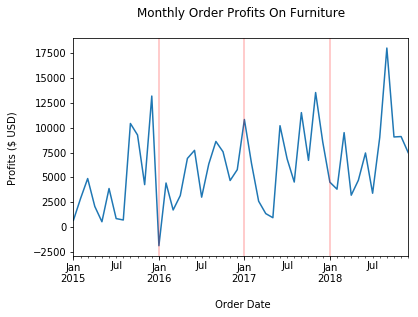

In [90]:
# Monthly Order Profits On Furniture (2015 - 2017)

furn_mth_profits.plot()

plt.xlabel('\n Order Date')
plt.ylabel('Profits ($ USD) \n')

# Vertical lines at start of each year
plt.axvline(x = '2016-01-01', linewidth=2, color='red', alpha = 0.2) 
plt.axvline(x = '2017-01-01', linewidth=2, color='red', alpha = 0.2)
plt.axvline(x = '2018-01-01', linewidth=2, color='red', alpha = 0.2)

plt.title('Monthly Order Profits On Furniture\n')

Furniture order profits are generally high in the second half of the year during back to school season and near the holidays.

## Using auto.arima() For Model Selection On Monthly Furniture Profits

In [126]:
### Train test split the furniture data:

# Training data is monthly profits from 2015 - 2017 

furn_profits_mth_train = furn_mth_profits[furn_mth_profits.index < '2018-01-01']

furn_profits_mth_train.tail()

Order_Date_Month
2017-08-01     4536.1751
2017-09-01    11511.9830
2017-10-01     6711.7821
2017-11-01    13528.8380
2017-12-01     8561.1667
Name: Profit, dtype: float64

In [127]:
# Test data for furniture is 2018 year

furn_profits_mth_test = furn_mth_profits[~(furn_mth_profits.index < '2018-01-01')]

furn_profits_mth_test.head()

Order_Date_Month
2018-01-01    4522.8185
2018-02-01    3819.1205
2018-03-01    9499.6973
2018-04-01    3214.5958
2018-05-01    4714.8752
Name: Profit, dtype: float64

In [128]:
# Using auto arima with Adj Dickey-Fuller stationarity test and BIC criterion.
# Got SARIMA(0, 0, 0)(0, 0, 0, 12) which is weird.

auto_arima(furn_profits_mth_train, test =  'adf', m = 12, stepwise = True, trace = True,
           information_criterion = 'bic')

/usr/local/lib/python3.6/dist-packages/pyramid/arima/auto.py:864: ModelFitWarning: Unable to fit ARIMA for order=(2, 0, 2) seasonal_order=(1, 0, 1, 12); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/usr/local/lib/python3.6/dist-packages/pyramid/arima/auto.py:864: ModelFitWarning: Unable to fit ARIMA for order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/usr/local/lib/python3.6/dist-packages/pyramid/arima/auto.py:864: ModelFitWarning: Unable to fit ARIMA for order=(0, 0, 0) seasonal_order=(0, 0, 1, 12); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/usr/local/lib/python3.6/dist-packages/pyramid/arima/auto.py:864: ModelFitWarning: Unable to fit ARIMA for order=(0, 0, 0) seasonal_order=(1, 0, 1, 12); data is likel

Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=700.148, BIC=703.315, Fit time=0.009 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=703.195, BIC=709.529, Fit time=0.091 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=701.913, BIC=706.664, Fit time=0.043 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=701.525, BIC=706.276, Fit time=0.019 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=701.768, BIC=706.518, Fit time=0.025 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=703.349, BIC=709.683, Fit

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 0, 0),
      out_of_sample_size=0, scoring='mse', scoring_args={},
      seasonal_order=(0, 0, 0, 12), solver='lbfgs', start_params=None,
      suppress_warnings=False, transparams=True, trend='c')

In [129]:
# Using auto arima with Adj Dickey-Fuller stationarity test and AIC criterion.
# Got SARIMA(0, 0, 0)(0, 0, 0, 12) which is weird.

auto_arima(furn_profits_mth_train, test =  'adf', m = 12, stepwise = True, trace = True,
           information_criterion = 'aic')

/usr/local/lib/python3.6/dist-packages/pyramid/arima/auto.py:864: ModelFitWarning: Unable to fit ARIMA for order=(2, 0, 2) seasonal_order=(1, 0, 1, 12); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/usr/local/lib/python3.6/dist-packages/pyramid/arima/auto.py:864: ModelFitWarning: Unable to fit ARIMA for order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/usr/local/lib/python3.6/dist-packages/pyramid/arima/auto.py:864: ModelFitWarning: Unable to fit ARIMA for order=(0, 0, 0) seasonal_order=(0, 0, 1, 12); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/usr/local/lib/python3.6/dist-packages/pyramid/arima/auto.py:864: ModelFitWarning: Unable to fit ARIMA for order=(0, 0, 0) seasonal_order=(1, 0, 1, 12); data is likel

Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=700.148, BIC=703.315, Fit time=0.009 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=703.195, BIC=709.529, Fit time=0.088 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=701.913, BIC=706.664, Fit time=0.040 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=701.525, BIC=706.276, Fit time=0.020 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=701.768, BIC=706.518, Fit time=0.024 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=703.349, BIC=709.683, Fit

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 0, 0),
      out_of_sample_size=0, scoring='mse', scoring_args={},
      seasonal_order=(0, 0, 0, 12), solver='lbfgs', start_params=None,
      suppress_warnings=False, transparams=True, trend='c')

Both `auto.arima` outputs with AIC and BIC with Adjusted Dickey Fuller Test gives
SARIMA(0, 0, 0) x (0, 0, 0, 12) also.

I am going to try SARIMA(1, 0, 0) x (1, 0, 0, 12) as the AIC & BIC values are low compared to the other
fitted SARIMA models from the output above.

## Showing Why Model Fit On SARIMA(0, 0, 0) x (0, 0, 0, 12) Is Bad

In [148]:
# Both auto.arima outputs with AIC and BIC with Adjusted Dickey Fuller Test gives
# SARIMA(0, 0, 0) x (0, 0, 0, 12) also.

# Reference: https://www.datasciencesmachinelearning.com/2019/01/arimasarima-in-python.html

# Trying SARIMA(0, 0, 0) x (0, 0, 0, 12)

furn_profits_model_train_000 = sm.tsa.statespace.SARIMAX(furn_profits_mth_train,
                                       order = (0, 0, 0),
                                       seasonal_order = (0, 0, 0, 12),
                                       enforce_stationarity = False,
                                       enforce_invertibility = False)

results_furn_model_train_000 = furn_profits_model_train_000.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


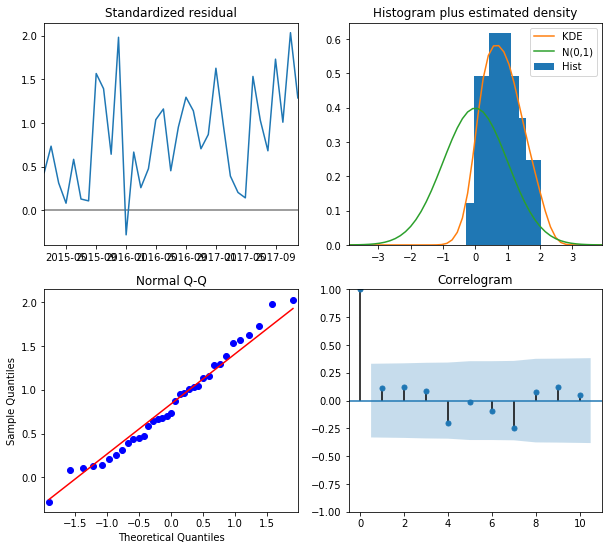

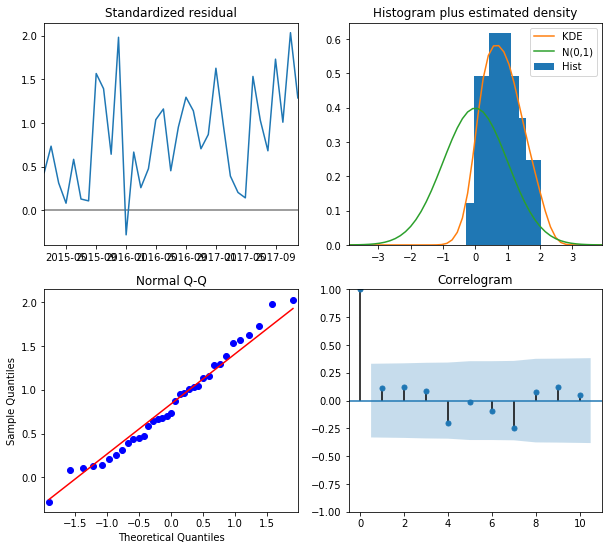

In [149]:
# Plot Model Diagnostics:

results_furn_model_train_000.plot_diagnostics(figsize = (10, 9))

### Forecasts On Monthly Furniture Profits

In [147]:
# Obtain forecasts for 2018 from SARIMA(0, 0, 0) x (0, 0, 0, 12) on office supplies mthly profits.

forecasts_furn_profits_000 = results_furn_model_train_000.get_forecast(steps = 12)

# Bad predictions, zero mean is very bad as it does not capture a trend.
forecasts_furn_profits_000.summary_frame()

Profit,mean,mean_se,mean_ci_lower,mean_ci_upper
2018-01-01,0.0,6652.351045,-13038.368461,13038.368461
2018-02-01,0.0,6652.351045,-13038.368461,13038.368461
2018-03-01,0.0,6652.351045,-13038.368461,13038.368461
2018-04-01,0.0,6652.351045,-13038.368461,13038.368461
2018-05-01,0.0,6652.351045,-13038.368461,13038.368461
2018-06-01,0.0,6652.351045,-13038.368461,13038.368461
2018-07-01,0.0,6652.351045,-13038.368461,13038.368461
2018-08-01,0.0,6652.351045,-13038.368461,13038.368461
2018-09-01,0.0,6652.351045,-13038.368461,13038.368461
2018-10-01,0.0,6652.351045,-13038.368461,13038.368461


## Model Fit On SARIMA(1, 0, 0) x (1, 0, 0, 12)

In [182]:
# Both auto.arima outputs with AIC and BIC with Adjusted Dickey Fuller Test gives
# SARIMA(0, 0, 0) x (0, 0, 0, 12) also.

# Reference: https://www.datasciencesmachinelearning.com/2019/01/arimasarima-in-python.html

# Trying SARIMA(1, 0, 0) x (1, 0, 0, 12)

furn_profits_model_train = sm.tsa.statespace.SARIMAX(furn_profits_mth_train,
                                       order = (1, 0, 0),
                                       seasonal_order = (1, 0, 0, 12),
                                       enforce_stationarity = False,
                                       enforce_invertibility = False)

results_furn_model_train = furn_profits_model_train.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


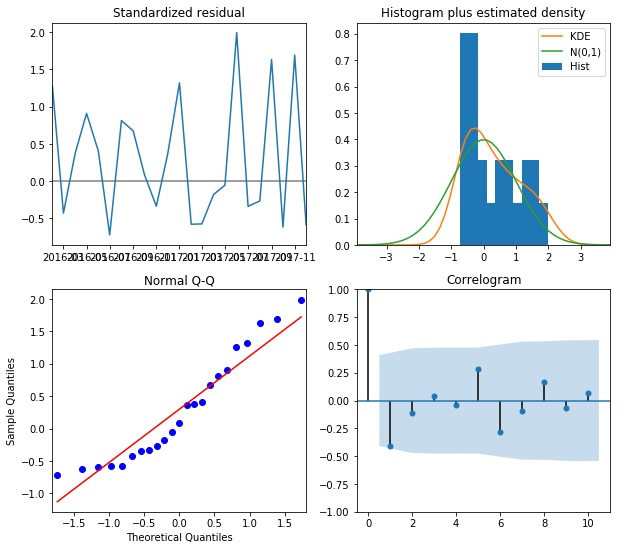

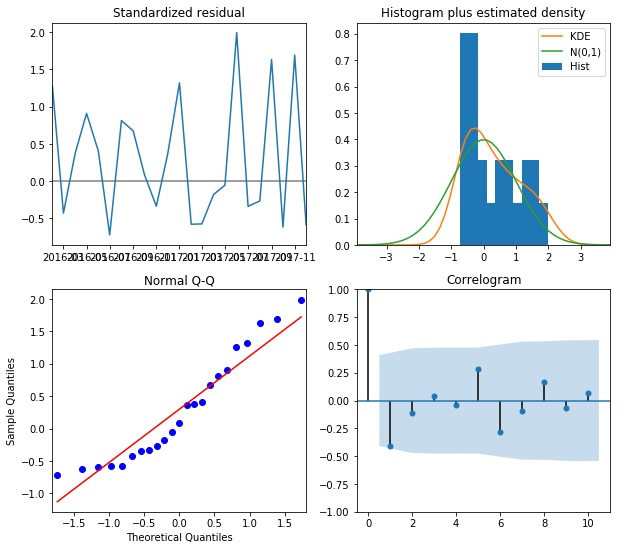

In [171]:
# Plot Model Diagnostics:

results_furn_model_train.plot_diagnostics(figsize = (10, 9))

### Forecasted Monthly Profits On Furniture

In [172]:
# Obtain forecasts for 2018 from SARIMA(1, 0, 0) x (1, 0, 0, 12) on office supplies mthly profits.

forecasts_furn_profits_100 = results_furn_model_train.get_forecast(steps = 12)

forecasts_furn_profits_100.summary_frame()

Profit,mean,mean_se,mean_ci_lower,mean_ci_upper
2018-01-01,7234.557040,4706.969853,-1990.934349,16460.048428
2018-02-01,5993.817957,6129.535203,-6019.850283,18007.486196
2018-03-01,4957.262208,6949.622915,-8663.748411,18578.272827
2018-04-01,4122.385243,7467.285280,-10513.224967,18757.995454
2018-05-01,3435.747340,7807.246553,-11866.174723,18737.669403
2018-06-01,3012.150682,8035.307430,-12736.762486,18761.063850
2018-07-01,2487.000826,8190.244429,-13565.583281,18539.584932
2018-08-01,2056.027599,8296.341287,-14204.502527,18316.557726
2018-09-01,1835.224046,8369.369059,-14568.437883,18238.885974
2018-10-01,1485.869702,8419.807437,-15016.649631,17988.389035


In [271]:
# Obtain forecasts for 2018 for the ARIMA model

forecasts_mean_furn_profits100 = forecasts_office_profits_100.summary_frame()['mean']

forecasts_mean_furn_profits100

2018-01-01    25513.829716
2018-02-01    25770.083631
2018-03-01    26743.649159
2018-04-01    26948.056320
2018-05-01    28706.322424
2018-06-01    29138.517730
2018-07-01    30371.205393
2018-08-01    30750.522864
2018-09-01    32272.228971
2018-10-01    32541.947253
2018-11-01    34376.973109
2018-12-01    37236.811992
Freq: MS, Name: mean, dtype: float64

### RMSE, Correlation & Mean Abs. Pct Error

In [272]:
# Root Mean Squared Error - Square of Predictions - Acutal (Test) Values:

mse_profit_furn_100 = np.mean((forecasts_mean_furn_profits100 - furn_profits_mth_test)**2)

rmse_profit_furn_100 = mse_profit_furn_100 ** 0.5

rmse_profit_furn_100

22924.907579216582

In [273]:
# Correlation Between Forecasted 2018 Values & Actual 2018 Sales Per Month

corr_profits_furn_100 = np.corrcoef(forecasts_mean_furn_profits100, furn_profits_mth_test)

corr_profits_furn_100

array([[1.        , 0.44808496],
       [0.44808496, 1.        ]])

In [276]:
# Mean Absolute Percentage Error
# 4.00 is very bad. Not sure what is going on.

mean_abs_percent_error_profits_100 = np.mean(np.abs(forecasts_mean_furn_profits100 - furn_profits_mth_test)/np.abs(furn_profits_mth_test)) 

mean_abs_percent_error_profits_100

4.002572345826489

## Final Model For Furniture Profits - SARIMA(1, 0, 0) x (1, 0, 0, 12)

In [249]:
# SARIMA Model For Monthly Furniture Profits

# Reference: https://www.datasciencesmachinelearning.com/2019/01/arimasarima-in-python.html

# Trying SARIMA(1, 0, 0) x (1, 0, 0, 12)

furn_profits_finalmodel = sm.tsa.statespace.SARIMAX(furn_mth_profits,
                                       order = (1, 0, 0),
                                       seasonal_order = (1, 0, 0, 12),
                                       enforce_stationarity = False,
                                       enforce_invertibility = False)

results_furn_finalmodel = furn_profits_finalmodel.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


**Obtain Forecasts For 2019**

In [250]:
# Obtain forecasts for 2019 from SARIMA(1, 0, 1) x (0, 0, 0, 12) on furniture
# monthly profits.

forecasts_furn_profits_final = results_furn_finalmodel.get_forecast(steps = 12)

forecasts_furn_profits_final.summary_frame()

Profit,mean,mean_se,mean_ci_lower,mean_ci_upper
2019-01-01,5252.976617,4743.270068,-4043.661884,14549.615119
2019-02-01,4055.262221,5946.601922,-7599.863377,15710.387818
2019-03-01,4445.650637,6535.800837,-8364.283614,17255.584888
2019-04-01,2533.659083,6849.938479,-10891.973633,15959.291799
2019-05-01,2392.302733,7023.234564,-11372.984069,16157.589534
2019-06-01,2620.476054,7120.420876,-11335.292418,16576.244525
2019-07-01,1516.918744,7175.395216,-12546.597455,15580.434943
2019-08-01,2490.277655,7206.638085,-11634.473441,16615.028751
2019-09-01,4215.333965,7224.440324,-9944.308878,18374.976807
2019-10-01,2239.508978,7234.598978,-11940.044461,16419.062417


In [251]:
# Obtain mean column of predictions:


forecasts_mean_furn_profits = forecasts_furn_profits_final.summary_frame()['mean']

forecasts_mean_furn_profits

2019-01-01    5252.976617
2019-02-01    4055.262221
2019-03-01    4445.650637
2019-04-01    2533.659083
2019-05-01    2392.302733
2019-06-01    2620.476054
2019-07-01    1516.918744
2019-08-01    2490.277655
2019-09-01    4215.333965
2019-10-01    2239.508978
2019-11-01    2162.919338
2019-12-01    1760.585739
Freq: MS, Name: mean, dtype: float64

In [252]:
# Monthly Furniture profits before 2019 and including the forecasted 
# January 2019 sales (to connect lines in plot)

furn_profits_pre2019 = furn_mth_profits.append(forecasts_mean_furn_profits.head(1))

furn_profits_pre2019.tail()

2018-09-01    17999.272000
2018-10-01     9066.217400
2018-11-01     9106.120000
2018-12-01     7485.263500
2019-01-01     5252.976617
dtype: float64

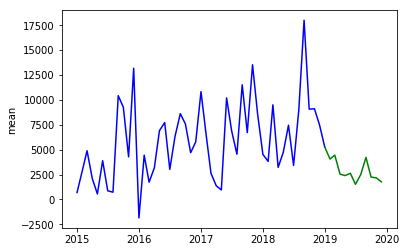

In [253]:
# Furniture Monthly Profit Line Plots (Blue is historical data, green is forecasted)

sns.lineplot(x = furn_profits_pre2019.index, y = furn_profits_pre2019, color = 'blue')
sns.lineplot(x = forecasts_mean_furn_profits.index, y = forecasts_mean_furn_profits, color = 'green')
#plt.axvline(pd.Timestamp('2019-01-01'), color= 'green', alpha = 0.5)

# 3) SARIMA Model On Monthly Technology Profits

In [255]:
# Retail data with technology:

retail_data_tech = retail_data[retail_data['Category'] == 'Technology']

retail_data_tech.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country,Postal Code,Market,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority,Order_Date_Month
0,32298,CA-2016-124891,2016-07-31,2016-07-31,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,United States,10024.0,US,East,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical,2016-07-01
2,25330,IN-2017-71249,2017-10-17,2017-10-18,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,Australia,NaN,APAC,Oceania,TEC-PH-10004664,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium,2017-10-01
3,13524,ES-2017-1579342,2017-01-28,2017-01-30,First Class,KM-16375,Katherine Murray,Home Office,Berlin,Berlin,Germany,NaN,EU,Central,TEC-PH-10004583,Technology,Phones,"Motorola Smart Phone, Cordless",2892.510,5,0.1,-96.5400,910.16,Medium,2017-01-01
4,47221,SG-2017-4320,2017-11-05,2017-11-06,Same Day,RH-9495,Rick Hansen,Consumer,Dakar,Dakar,Senegal,NaN,Africa,Africa,TEC-SHA-10000501,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.960,8,0.0,311.5200,903.04,Critical,2017-11-01
5,22732,IN-2017-42360,2017-06-28,2017-07-01,Second Class,JM-15655,Jim Mitchum,Corporate,Sydney,New South Wales,Australia,NaN,APAC,Oceania,TEC-PH-10000030,Technology,Phones,"Samsung Smart Phone, with Caller ID",2862.675,5,0.1,763.2750,897.35,Critical,2017-06-01


In [256]:
# From retail data with technology only, group by month and find 
# total profits for each month.

tech_mth_profits = retail_data_furn.groupby(['Order_Date_Month'])['Profit'].sum()

tech_mth_profits.head()

Order_Date_Month
2015-01-01    3056.86196
2015-02-01    7203.10018
2015-03-01    4003.85226
2015-04-01    5138.18768
2015-05-01    6555.29900
Name: Profit, dtype: float64

Text(0.5, 1.0, 'Monthly Order Profits On Technology\n')

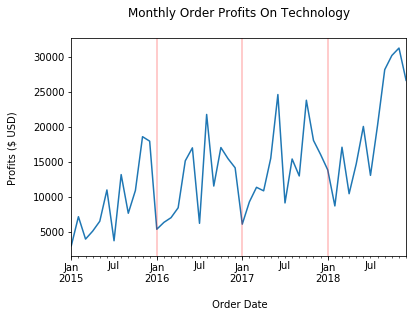

In [258]:
# Monthly Order Profits On Technology (2015 - 2018)

tech_mth_profits.plot()

plt.xlabel('\n Order Date')
plt.ylabel('Profits ($ USD) \n')

# Vertical lines at start of each year
plt.axvline(x = '2016-01-01', linewidth=2, color='red', alpha = 0.2) 
plt.axvline(x = '2017-01-01', linewidth=2, color='red', alpha = 0.2)
plt.axvline(x = '2018-01-01', linewidth=2, color='red', alpha = 0.2)

plt.title('Monthly Order Profits On Technology\n')

## Using auto.arima() For Model Selection On Monthly Technology Profits

In [259]:
### Train test split the technology data:

# Training data is monthly profits from 2015 - 2017 

tech_mth_profits_train = tech_mth_profits[tech_mth_profits.index < '2018-01-01']

tech_mth_profits.tail()

Order_Date_Month
2018-08-01    20314.92606
2018-09-01    28210.42150
2018-10-01    30232.27646
2018-11-01    31297.68640
2018-12-01    26679.98868
Name: Profit, dtype: float64

In [260]:
### Test data is 2018 for technology:

tech_mth_profits_test = tech_mth_profits[~(tech_mth_profits.index < '2018-01-01')]

tech_mth_profits_test.tail()

Order_Date_Month
2018-08-01    20314.92606
2018-09-01    28210.42150
2018-10-01    30232.27646
2018-11-01    31297.68640
2018-12-01    26679.98868
Name: Profit, dtype: float64

In [263]:
# Using auto arima with Adj Dickey-Fuller stationarity test and BIC criterion.

auto_arima(tech_mth_profits_train, test =  'adf', m = 12, stepwise = True, trace = True,
           information_criterion = 'bic')

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.6/dist-packages/pyramid/arima/auto.py:864: ModelFitWarning: Unable to fit ARIMA for order=(2, 0, 2) seasonal_order=(1, 0, 1, 12); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/loca

Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=728.649, BIC=731.816, Fit time=0.012 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=725.330, BIC=731.664, Fit time=0.058 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=728.032, BIC=732.783, Fit time=0.020 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 0, 12); AIC=725.062, BIC=732.979, Fit time=0.201 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=729.423, BIC=734.173, Fit time=0.035 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=723.950, BIC=731.867, Fit

/usr/local/lib/python3.6/dist-packages/pyramid/arima/auto.py:864: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 0) seasonal_order=(1, 0, 1, 12); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/usr/local/lib/python3.6/dist-packages/pyramid/arima/auto.py:864: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 0) seasonal_order=(2, 0, 1, 12); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starti

Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 0, 0, 12); AIC=722.323, BIC=730.241, Fit time=0.146 seconds


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: Us

Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 0, 12); AIC=717.295, BIC=728.380, Fit time=0.607 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 12); AIC=727.977, BIC=737.479, Fit time=0.227 seconds


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: Us

Fit ARIMA: order=(2, 0, 2) seasonal_order=(2, 0, 0, 12); AIC=723.494, BIC=736.162, Fit time=1.302 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(2, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Fit ARIMA: order=(1, 0, 2) seasonal_order=(1, 0, 0, 12); AIC=714.962, BIC=724.463, Fit time=0.492 seconds


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Fit ARIMA: order=(1, 0, 3) seasonal_order=(1, 0, 0, 12); AIC=719.807, BIC=730.892, Fit time=0.519 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 0, 0, 12); AIC=730.602, BIC=736.936, Fit time=0.053 seconds


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Fit ARIMA: order=(2, 0, 3) seasonal_order=(1, 0, 0, 12); AIC=725.120, BIC=737.788, Fit time=0.650 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 0, 0, 12); AIC=730.005, BIC=737.922, Fit time=0.047 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(2, 0, 0, 12); AIC=715.882, BIC=726.967, Fit time=1.076 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(1, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(2, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 2) seasonal_order=(1, 0, 0, 12); AIC=730.752, BIC=738.670, Fit time=0.076 seconds
Total fit time: 5.655 seconds


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/pyramid/arima/auto.py:864: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 2) seasonal_order=(1, 0, 1, 12); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/usr/local/lib/python3.6/dist-packages/pyramid/arima/auto.py:864: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 2) seasonal_order=(2, 0, 1, 12); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(1, 0, 2),
      out_of_sample_size=0, scoring='mse', scoring_args={},
      seasonal_order=(1, 0, 0, 12), solver='lbfgs', start_params=None,
      suppress_warnings=False, transparams=True, trend='c')

The suggested SARIMA model of SARIMA(1, 0, 2) x (1, 0, 0, 12) seems reasonable. Check if prediction scores on test set seems okay.

## Model Fit On SARIMA(1, 0, 2) x (1, 0, 0, 12)

In [264]:
# Both auto.arima outputs with AIC and BIC with Adjusted Dickey Fuller Test gives
# SARIMA(0, 0, 0) x (0, 0, 0, 12) also.

# Reference: https://www.datasciencesmachinelearning.com/2019/01/arimasarima-in-python.html

# Trying SARIMA(1, 0, 2) x (1, 0, 0, 12)

tech_profits_model_102 = sm.tsa.statespace.SARIMAX(tech_mth_profits_train,
                                       order = (1, 0, 2),
                                       seasonal_order = (1, 0, 0, 12),
                                       enforce_stationarity = False,
                                       enforce_invertibility = False)

results_tech_model_102 = tech_profits_model_102.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


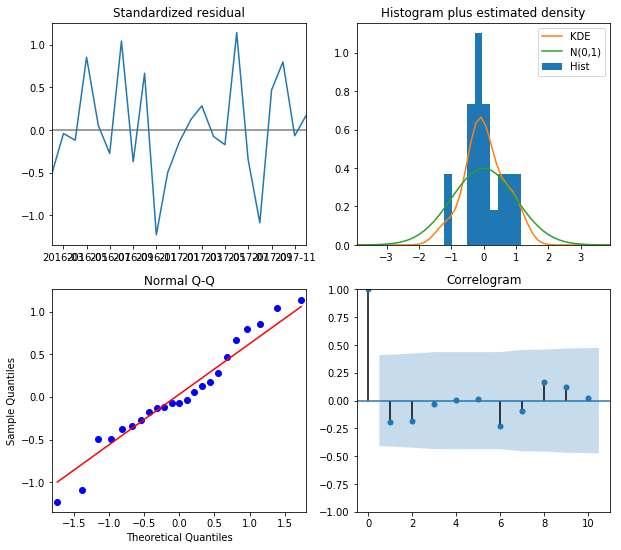

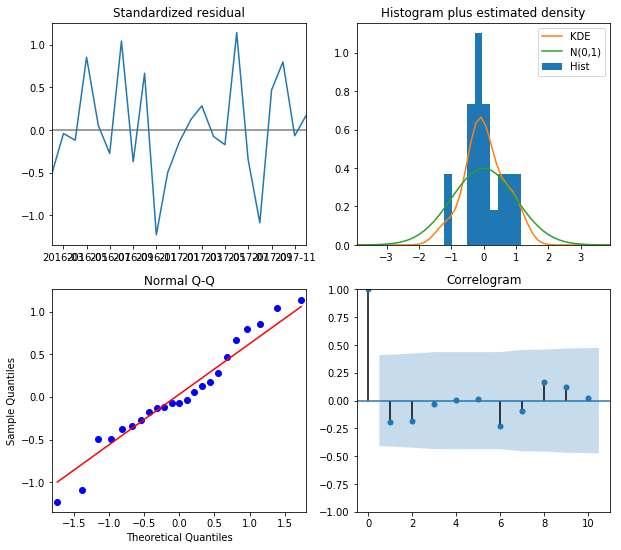

In [265]:
# Plot Model Diagnostics:

results_tech_model_102.plot_diagnostics(figsize = (10, 9))

### Forecasted Monthly Profits On Technology

In [266]:
# Obtain forecasts for 2018 from SARIMA(1, 0, 2) x (1, 0, 0, 12) on technology mthly profits.

forecasts_tech_profits_102 = results_tech_model_102.get_forecast(steps = 12)

forecasts_tech_profits_102.summary_frame()

Profit,mean,mean_se,mean_ci_lower,mean_ci_upper
2018-01-01,8112.049833,5898.538096,-3448.872395,19672.972062
2018-02-01,10572.158541,6440.430239,-2050.852772,23195.169855
2018-03-01,12423.445661,6440.833060,-200.355166,25047.246488
2018-04-01,11876.450676,6441.201718,-748.072708,24500.974059
2018-05-01,16127.659934,6441.539112,3502.475270,28752.844598
2018-06-01,24504.854601,6441.847895,11879.064733,37130.644470
2018-07-01,10052.869810,6442.130495,-2573.473943,22679.213564
2018-08-01,15815.806611,6442.389132,3188.955937,28442.657285
2018-09-01,13501.482797,6442.625840,874.168184,26128.797410
2018-10-01,23488.905938,6442.842479,10861.166721,36116.645155


In [267]:
# Obtain forecasts for 2018 on technology

forecasts_mean_tech_profits102 = forecasts_tech_profits_102.summary_frame()['mean']

forecasts_mean_tech_profits102

2018-01-01     8112.049833
2018-02-01    10572.158541
2018-03-01    12423.445661
2018-04-01    11876.450676
2018-05-01    16127.659934
2018-06-01    24504.854601
2018-07-01    10052.869810
2018-08-01    15815.806611
2018-09-01    13501.482797
2018-10-01    23488.905938
2018-11-01    18097.060962
2018-12-01    16164.368471
Freq: MS, Name: mean, dtype: float64

### RMSE, Correlation & Mean Abs. Pct Error

In [277]:
# Root Mean Squared Error - Square of Predictions - Acutal (Test) Values:

mse_profit_tech_102 = np.mean((forecasts_mean_tech_profits102 - tech_mth_profits_test)**2)

rmse_profit_tech_102 = mse_profit_tech_102 ** 0.5

rmse_profit_tech_102

7406.931010160525

In [278]:
# Correlation Between Forecasted 2018 Values & Actual 2018 Sales Per Month

corr_profits_tech_102 = np.corrcoef(forecasts_mean_tech_profits102, tech_mth_profits_test)

corr_profits_tech_102

array([[1.        , 0.62647415],
       [0.62647415, 1.        ]])

In [279]:
# Mean Absolute Percentage Error
# 73.8 % Error on Test set not a great prediction.

mean_abs_percent_error_profits_102 = np.mean(np.abs(forecasts_mean_furn_profits100 - tech_mth_profits_test)/np.abs(tech_mth_profits_test)) 

mean_abs_percent_error_profits_102

0.7382176356569511

## Final Model Fit On SARIMA(1, 0, 2) x (1, 0, 0, 12)

In [283]:
# Both auto.arima outputs with AIC and BIC with Adjusted Dickey Fuller Test gives
# SARIMA(0, 0, 0) x (0, 0, 0, 12) also.

# Reference: https://www.datasciencesmachinelearning.com/2019/01/arimasarima-in-python.html

# Trying SARIMA(1, 0, 2) x (1, 0, 0, 12)

tech_profits_finalmodel = sm.tsa.statespace.SARIMAX(tech_mth_profits,
                                       order = (1, 0, 2),
                                       seasonal_order = (1, 0, 0, 12),
                                       enforce_stationarity = False,
                                       enforce_invertibility = False)

results_tech_finalmodel = tech_profits_finalmodel.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [284]:
# Obtain forecasts for 2019 from SARIMA(1, 0, 2) x (1, 0, 0, 12) on technology
# monthly profits.

forecasts_tech_profits_final = results_tech_finalmodel.get_forecast(steps = 12)

forecasts_tech_profits_final.summary_frame()

Profit,mean,mean_se,mean_ci_lower,mean_ci_upper
2019-01-01,24027.487679,5831.409432,12598.135214,35456.840144
2019-02-01,20844.845055,6501.692569,8101.761780,33587.928329
2019-03-01,26406.083030,6782.200277,13113.214750,39698.951309
2019-04-01,22342.487639,7058.145635,8508.776397,36176.198881
2019-05-01,25266.827061,7330.202060,10899.895025,39633.759098
2019-06-01,28887.017549,7598.943616,13993.361740,43780.673358
2019-07-01,24610.732569,7864.864958,9195.880508,40025.584630
2019-08-01,29427.338094,8128.396435,13495.973829,45358.702358
2019-09-01,34687.582375,8389.915730,18243.649712,51131.515039
2019-10-01,36188.504996,8649.756940,19235.292917,53141.717074


In [286]:
# Obtain forecasts for 2018 on technology

forecasts_mean_tech_profits_final = forecasts_tech_profits_final.summary_frame()['mean']

forecasts_mean_tech_profits_final

2019-01-01    24027.487679
2019-02-01    20844.845055
2019-03-01    26406.083030
2019-04-01    22342.487639
2019-05-01    25266.827061
2019-06-01    28887.017549
2019-07-01    24610.732569
2019-08-01    29427.338094
2019-09-01    34687.582375
2019-10-01    36188.504996
2019-11-01    37079.414248
2019-12-01    34333.093787
Freq: MS, Name: mean, dtype: float64

In [287]:
# Monthly Furniture profits before 2019 and including the forecasted 
# January 2019 sales (to connect lines in plot)

tech_profits_pre2019 = tech_mth_profits.append(forecasts_mean_tech_profits_final.head(1))

tech_profits_pre2019.tail()

2018-09-01    28210.421500
2018-10-01    30232.276460
2018-11-01    31297.686400
2018-12-01    26679.988680
2019-01-01    24027.487679
dtype: float64

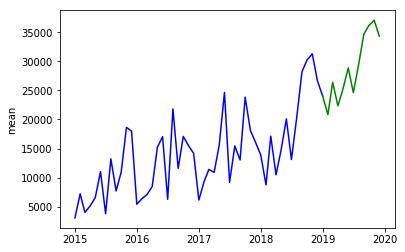

In [289]:
# Technology Monthly Profit Line Plots (Blue is historical data, green is forecasted)

sns.lineplot(x = tech_profits_pre2019.index, y = tech_profits_pre2019, color = 'blue')
sns.lineplot(x = forecasts_mean_tech_profits_final.index, y = forecasts_mean_tech_profits_final, color = 'green')
#plt.axvline(pd.Timestamp('2019-01-01'), color= 'green', alpha = 0.5)